In [48]:
# %% 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.graph_objects as go

# Anzeigeeinstellungen
pd.set_option('display.max_rows', 10)
plt.rcParams['figure.figsize'] = (10, 5)


In [ ]:
# %%
# Verzeichnis und Filenamen
data_dir = Path(r"C:\Users\malte\PycharmProjects\RideSync\phase_measurements")
files = [
    "Venloer_4279001084.csv",
    "Vogelsanger_2107720091.csv",
    "Weinsbergstr_2603639844.csv",
    "Hollar_8546960460.csv",
    "Aachener_750549269.csv"
]

# Alle Daten in Dict von DataFrames laden
dfs = {}
for fn in files:
    code = fn.split(".")[0]  # z.B. "Venloer_4279001084"
    path = data_dir / fn
    df = pd.read_csv(path, sep=",")
    # Timestamp parsen
    df['Time'] = pd.to_datetime(df['Time'])
    dfs[code] = df

# Kurzer Blick
for code, df in dfs.items():
    print(code, "– Einträge:", len(df))
    display(df.head(15))


In [33]:
# %%
phase_stats = {}

for code, df in dfs.items():
    ev = df[df['Value'] != 0].copy()
    ev = ev.sort_values('Time').reset_index(drop=True)
    
    green = ev[ev['Value'] == +1]['Time'].reset_index(drop=True)
    red   = ev[ev['Value'] == -1]['Time'].reset_index(drop=True)
    
    n = min(len(green), len(red))
    green_cut = green.iloc[:n]
    red_cut   = red.iloc[:n]
    
    # Grünphase: von grün_start bis rot_start
    dur_green = (red_cut - green_cut).dt.total_seconds()

    # Rotphase: von rot_start bis nächster grün_start (inkl. letzter!)
    dur_red = (green.shift(-1) - red).dt.total_seconds().dropna()

    stats = {
        'mean_green_s': dur_green.mean(),
        'std_green_s':  dur_green.std(),
        'mean_red_s':   dur_red.mean(),
        'std_red_s':    dur_red.std(),
        'n_green_phases': len(dur_green),
        'n_red_phases':   len(dur_red)
    }
    phase_stats[code] = stats

stats_df = pd.DataFrame(phase_stats).T
stats_df


,mean_green_s,std_green_s,mean_red_s,std_red_s,n_green_phases,n_red_phases
Venloer_4279001084,64.80,8.167007,46.000000,6.855655,5.0,5.0
Vogelsanger_2107720091,56.00,0.000000,54.333333,0.577350,3.0,3.0
Weinsbergstr_2603639844,39.40,1.341641,70.600000,2.607681,5.0,5.0
Hollar_8546960460,89.50,5.686241,20.250000,3.095696,4.0,4.0
Aachener_750549269,54.75,1.707825,55.750000,1.892969,4.0,4.0


In [49]:

# Liste zur Aufnahme aller Marker
markers = []

# Diskrete y-Positionen für jede Ampel
ampel_ypos = {code: i for i, code in enumerate(dfs.keys())}

for code, df in dfs.items():
    df_sorted = df[df['Value'] != 0].sort_values("Time")
    y = ampel_ypos[code]
    
    # Grünswitches
    green_df = df_sorted[df_sorted['Value'] == 1]
    markers.append(go.Scatter(
        x=green_df['Time'],
        y=[y]*len(green_df),
        mode='markers',
        marker=dict(color='green', size=10),
        name=f"{code} – Grün",
        legendgroup=code,
        showlegend=True
    ))
    
    # Rotswitches
    red_df = df_sorted[df_sorted['Value'] == -1]
    markers.append(go.Scatter(
        x=red_df['Time'],
        y=[y]*len(red_df),
        mode='markers',
        marker=dict(color='red', size=10),
        name=f"{code} – Rot",
        legendgroup=code,
        showlegend=True
    ))

# Plot zusammenbauen
fig = go.Figure(data=markers)

fig.update_layout(
    title="Ampelphasen über Zeit",
    xaxis_title="Zeit",
    yaxis=dict(
        tickvals=list(ampel_ypos.values()),
        ticktext=list(ampel_ypos.keys()),
        title="Ampel",
        autorange='reversed'  # optional, falls du Reihenfolge umdrehen willst
    ),
    height=50 + len(dfs)*100,
    hovermode='closest'
)

fig.show()


In [50]:
# %%
import plotly.graph_objects as go
from datetime import timedelta

# Bekannter Zyklus
cycle_length = 110  # Sekunden
ref_code = "Venloer_4279001084"
ref_times = dfs[ref_code][dfs[ref_code]['Value'] == 1]['Time'].reset_index(drop=True)
t0 = ref_times.iloc[0]

# Offsets berechnen wie zuvor (gegen t0)
offset_seconds = {}
for code, df in dfs.items():
    if code == ref_code:
        continue
    gruen = df[df['Value'] == 1]['Time'].reset_index(drop=True)
    offset = ((gruen - t0).dt.total_seconds() % cycle_length).mean()
    offset_seconds[code] = offset

# Marker-Vorbereitung
shifted_markers = []

ampel_ypos = {code: i for i, code in enumerate(dfs.keys())}

for code, df in dfs.items():
    df = df[df['Value'] != 0].copy()
    df = df.sort_values("Time").reset_index(drop=True)
    y = ampel_ypos[code]
    
    if code == ref_code:
        # keine Verschiebung
        shifted_df = df.copy()
    else:
        first_gruen = df[df['Value'] == 1]['Time'].iloc[0]
        offset_s = offset_seconds[code]
        delta = (first_gruen - t0).total_seconds() - offset_s
        shifted_df = df.copy()
        shifted_df['Time'] = df['Time'] - timedelta(seconds=delta)

    # Plot: Grün
    green_df = shifted_df[shifted_df['Value'] == 1]
    shifted_markers.append(go.Scatter(
        x=green_df['Time'],
        y=[y]*len(green_df),
        mode='markers',
        marker=dict(color='green', size=10),
        name=f"{code} – Grün",
        legendgroup=code,
        showlegend=True
    ))

    # Plot: Rot
    red_df = shifted_df[shifted_df['Value'] == -1]
    shifted_markers.append(go.Scatter(
        x=red_df['Time'],
        y=[y]*len(red_df),
        mode='markers',
        marker=dict(color='red', size=10),
        name=f"{code} – Rot",
        legendgroup=code,
        showlegend=True
    ))

# Plot anzeigen
fig = go.Figure(data=shifted_markers)

fig.update_layout(
    title="Synchronisierte Ampelphasen nach Offset-Shift",
    xaxis_title="Zeit (verschoben in gemeinsamen Zyklus)",
    yaxis=dict(
        tickvals=list(ampel_ypos.values()),
        ticktext=list(ampel_ypos.keys()),
        title="Ampel"
    ),
    height=50 + len(dfs)*100,
    hovermode='closest'
)

fig.show()


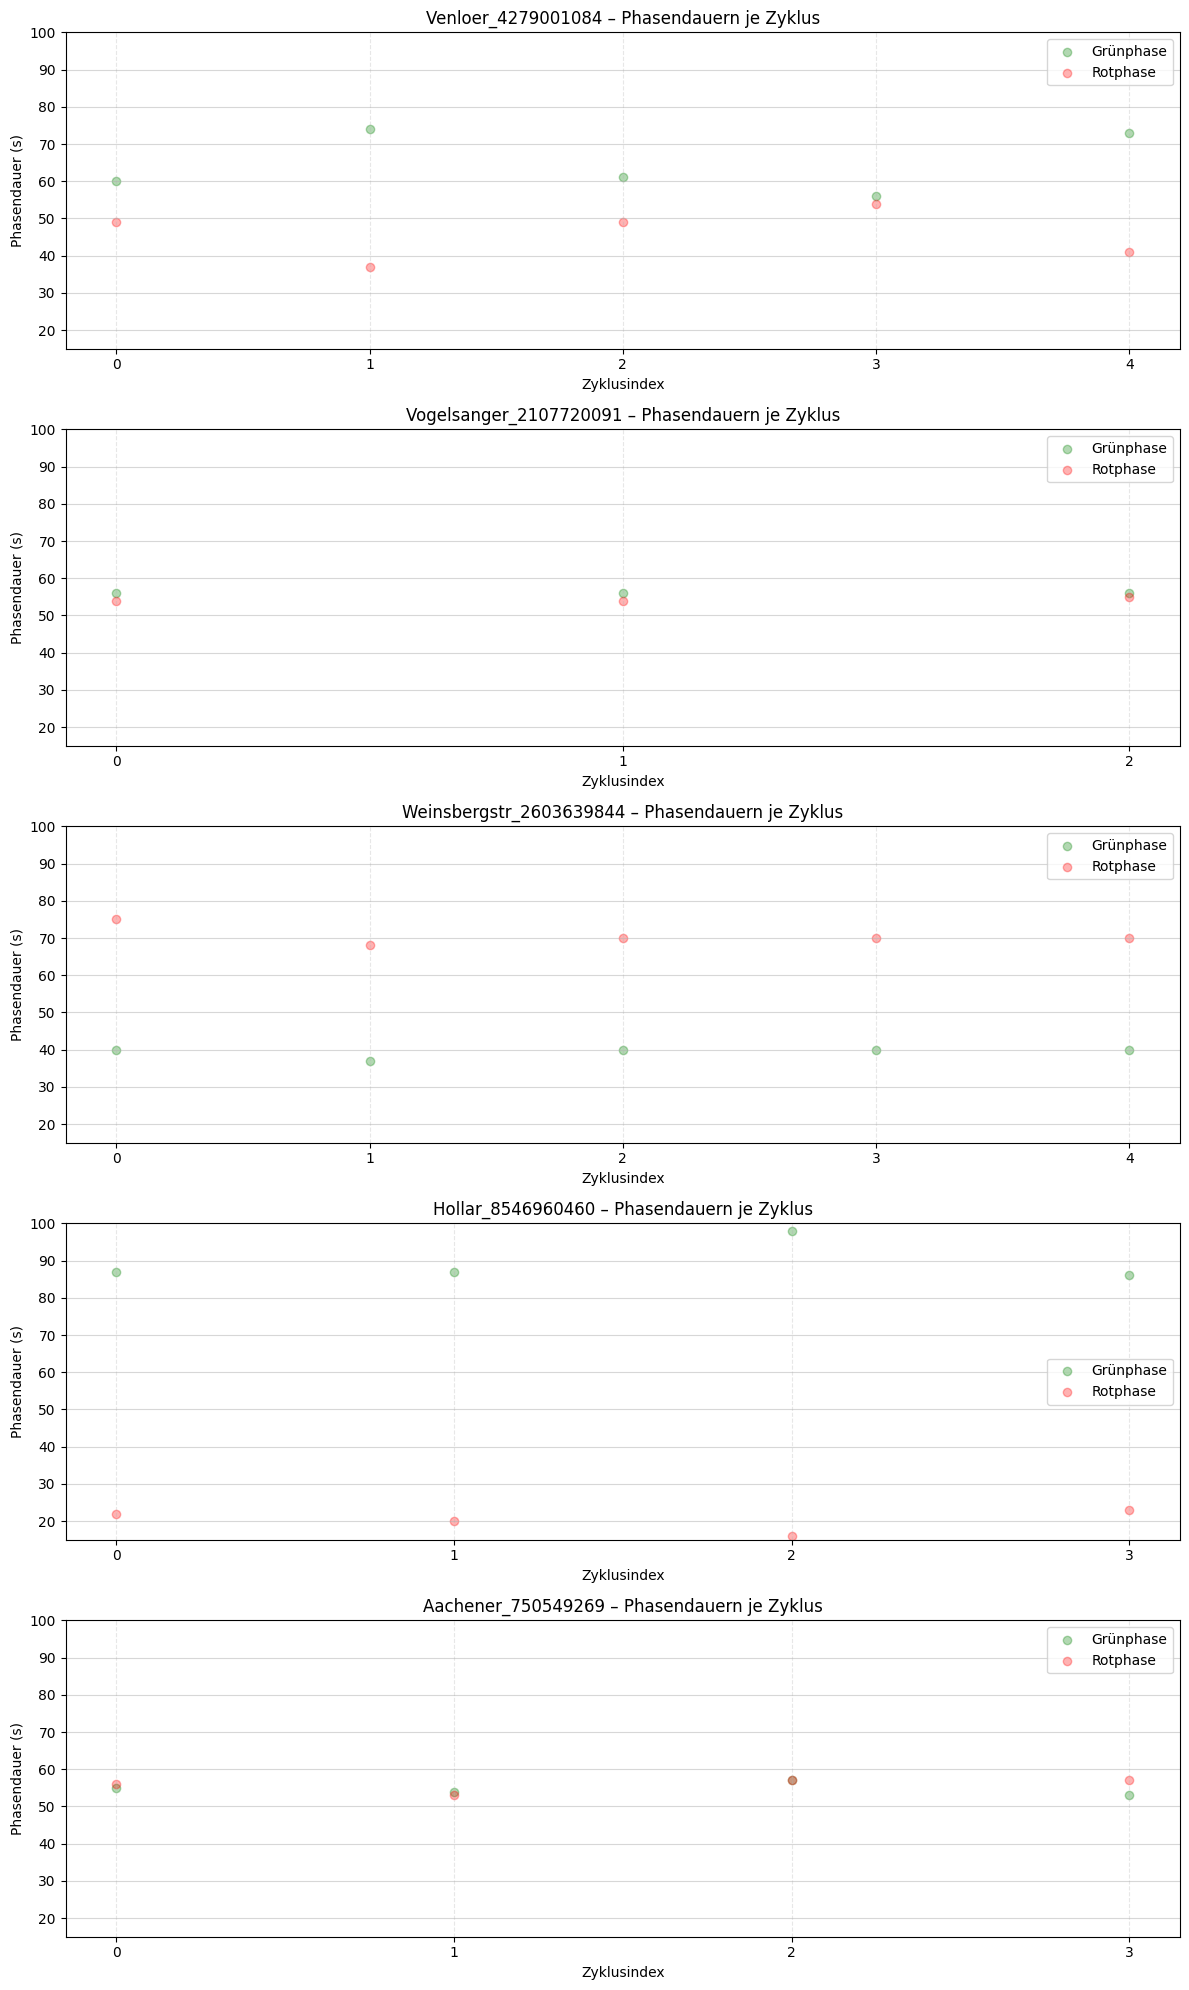

In [36]:
# %%
fig, axes = plt.subplots(len(dfs), 1, figsize=(12, 4*len(dfs)), sharex=False)

for idx, (code, df) in enumerate(dfs.items()):
    ev = df[df['Value'] != 0].sort_values('Time').reset_index(drop=True)
    green_times = ev[ev['Value'] == 1]['Time'].reset_index(drop=True)
    red_times   = ev[ev['Value'] == -1]['Time'].reset_index(drop=True)
    n = min(len(green_times), len(red_times))
    
    dur_green = (red_times.iloc[:n] - green_times.iloc[:n]).dt.total_seconds()
    dur_red = (green_times.shift(-1) - red_times).dt.total_seconds().dropna()


    x_green = np.arange(len(dur_green))
    x_red   = np.arange(len(dur_red))
    
    ax = axes[idx]
    ax.scatter(x_green, dur_green, label='Grünphase', color='green', alpha=0.3)
    ax.scatter(x_red,   dur_red,   label='Rotphase',  color='red',   alpha=0.3)
    
    ax.set_title(f"{code} – Phasendauern je Zyklus")
    ax.set_xlabel("Zyklusindex")
    ax.set_ylabel("Phasendauer (s)")
    ax.set_ylim(15, 100)
    
    # Nur ganzzahlige x-Ticks und vertikale Gitterlinien
    max_x = max(len(x_green), len(x_red))
    ax.set_xticks(np.arange(0, max_x))
    ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.3)
    ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.5)
    
    ax.legend()

plt.tight_layout()
plt.show()


In [51]:
# %%
cycle_length = 110  # Sekunden
ref_code = "Venloer_4279001084"

# Referenz-Grünstart-Zeitpunkt
ref_times = dfs[ref_code][dfs[ref_code]['Value'] == 1]['Time'].reset_index(drop=True)
t0 = ref_times.iloc[0]
ref_offsets = ((ref_times - t0).dt.total_seconds() % cycle_length)

offsets = {}

for code, df in dfs.items():
    if code == ref_code:
        continue
    times = df[df['Value'] == 1]['Time'].reset_index(drop=True)
    t0_other = times.iloc[0]
    other_offsets = ((times - t0).dt.total_seconds() % cycle_length)

    # Jetzt Differenzen der zyklischen Offsets berechnen
    # z. B. ref hat [5, 115, 225] → offset 5
    # andere hat [10, 120, 230] → offset 10 o440, → Versatz = 5 s
    diffs = (other_offsets - ref_offsets[:len(other_offsets)]) % cycle_length

    offsets[code] = {
        'mean_cycle_offset_s': np.mean(diffs),
        'std_cycle_offset_s':  np.std(diffs),
        'n_matched': len(diffs)
    }

pd.DataFrame(offsets).T


,mean_cycle_offset_s,std_cycle_offset_s,n_matched
Vogelsanger_2107720091,17.500000,0.500000,4.0
Weinsbergstr_2603639844,59.333333,2.924988,6.0
Hollar_8546960460,32.000000,1.549193,5.0
Aachener_750549269,64.800000,1.600000,5.0


---

**Nächste Schritte / Interpretation:**
- Aus `stats_df` erkennt man, wie konstant die Rot-/Grün-Dauern sind (Mittelwerte vs. Standardabweichung).
- Die Histogramme zeigen eventuelle Ausreißer oder Mehrmodalitäten.
- Die Offsets-Tabelle liefert, ob die Ampeln mit konstanter Zeitverschiebung zum Takt der Referenz-Ampel laufen.

Je nach Ergebnis kann man tiefer in die Kreuzkorrelation gehen oder Zeitreihenplots erstellen, um Phasenbeziehungen dynamisch zu visualisieren.
